In [2]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

%run ../DDELFI.py

import scipy as sp

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from delfi.simulator import Gauss

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib inline

In [3]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=False) / self.b.eval(samples, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
class MultipliedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, ii=None, log=True):
        ret = self.a.eval(samples, ii=ii, log=False) * self.b.eval(samples, ii=ii, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

def multiply_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a * b
    
    return MultipliedPdf(a, b, norm_region)

In [4]:
class BimodalGaussian(BaseSimulator):
    def __init__(self, slope, noise_var, seed = None):
        super().__init__(dim_param=1, seed=seed)
        self.slope = slope
        self.noise_var = noise_var
        
    def gen_single(self, params):
        dist = self.get_likelihood(params)
        sample = dist.gen(1).reshape(-1)
        return { 'data' : sample }
    
    def get_likelihood(self, params):
        return dd.MoG(a=[0.5, 0.5], ms=[self.slope * params, -self.slope * params], Ss = 2 * [np.eye(1) * self.noise_var])

In [5]:
def run_panel(algo, params, seed=None):
    if seed is None:
        seed = params.seed
        
    m = BimodalGaussian(params.slope, params.noise_cov, seed=seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=params.prior, summary=s)
    
    kws = { 'generator' : g,
            'obs' : [params.obs_stats],
            'n_hiddens' : params.n_hiddens,
            'seed' : seed,
            'verbose' : True,
            'svi' : False }
    
    run_kws = {}
    if algo == 'DDELFI':
        res = DDELFI(**kws, prior_mixin=0.1)
    elif algo == 'SNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000 }
    elif algo == 'kSNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000, 'kernel_loss' : 'x_kl' }
    elif algo == 'CDELFI':
        res = infer.CDELFI(**kws)
    else:
        raise NotImplemented("Unknown algorithm")
    
    ret = res.run(n_train=params.n_train, n_rounds = params.n_rounds, **run_kws)

    posteriors = ret[2]
    return posteriors

In [11]:
params = ParameterSet({})

params.seed = 399
params.n_hiddens = [ 20 ] * 2

params.noise_cov = 0.1

params.n_train = 5000
params.n_rounds = 3

params.prior_width = 5

params.n_runs = 50

params.slope = 3

params.true_params = np.array([ 3 ])

In [12]:
params.prior = dd.Uniform(lower=-params.prior_width, upper=params.prior_width)

params.obs_stats = params.true_params * params.slope

params.gt = dd.MoG(a=[0.5,0.5], ms=[params.obs_stats / params.slope, -params.obs_stats / params.slope], 
                   Ss = 2 * [np.eye(1) * params.noise_cov])

In [13]:
COL = { 'DDELFI' : 'orange', 'SNPE' : 'r', 'kSNPE' : 'g', 'CDELFI' : 'k' }

In [14]:
def plot_row(data):
    plt.figure(figsize=(16,5))
    
    algos = data.keys()
    
    xlist = np.linspace(-params.prior_width, params.prior_width, 200)
    
    for i, algo in enumerate(algos):
        plt.subplot(1, len(algos), i + 1)
        
        for posterior in data[algo]:
            if posterior is not None:
                ylist = posterior.eval(xlist.reshape(-1,1), log=False)
                ls = '--'

                if posterior == data[algo][-1]:
                    ls = None

                plt.plot(xlist, ylist, color=COL[algo], linewidth=2, ls=ls)
                
        ax = plt.gca()
        ax.set_title(algo)
        ax.set_yticks([])
        ax.axvline(params.true_params, color='gray', ls='--')
        plt.xticks([params.true_params], ['$x_o$'])
            
        plt.legend()
        
    plt.show()
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43846893]: : 4it [00:00, 31.43it/s]

loss=[ 2.41158915]: : 1719it [00:24, 70.65it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.3891654]: : 13it [00:00, 104.27it/s] 

loss=[ 2.38910413]: : 1025it [00:09, 109.30it/s]


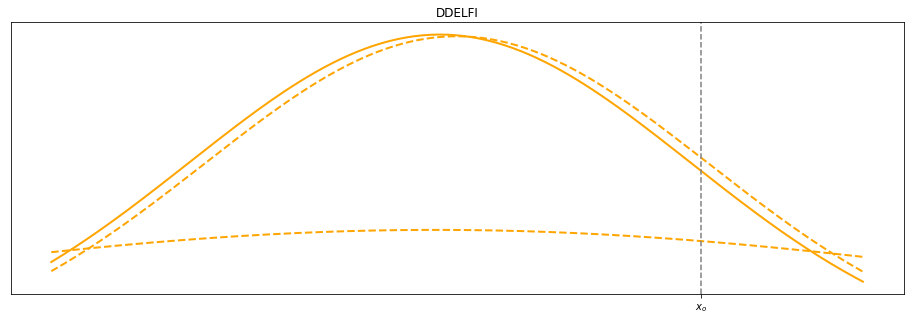

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40989113]: : 15it [00:00, 99.42it/s] 

loss=[ 2.39475989]: : 1684it [00:14, 116.43it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41358328]: : 0it [00:00, ?it/s]

loss=[ 2.41351271]: : 1042it [00:20, 50.37it/s]


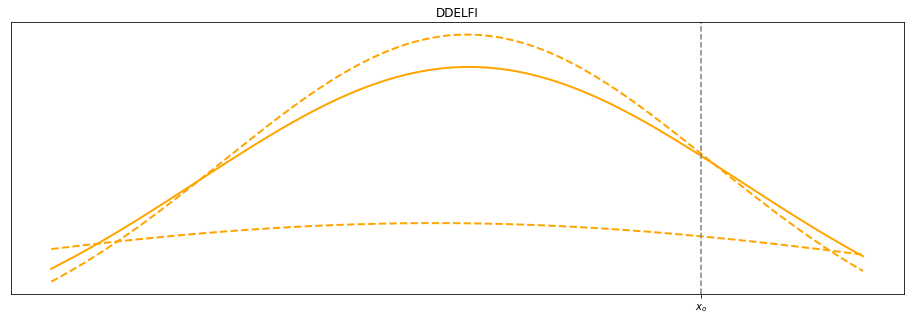

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41456127]: : 5it [00:00, 35.04it/s]

loss=[ 2.38500142]: : 1538it [00:33, 45.61it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4042089]: : 0it [00:00, ?it/s] 

loss=[ 2.40360856]: : 1037it [00:22, 45.40it/s]


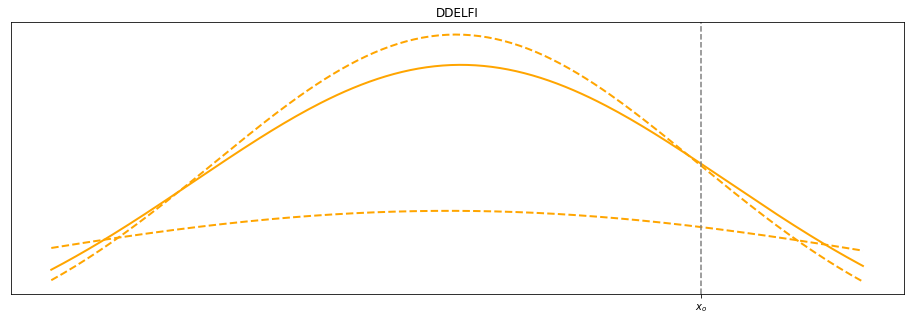

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43480849]: : 3it [00:00, 23.52it/s]

loss=[ 2.40719724]: : 1562it [00:26, 59.04it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40348744]: : 12it [00:00, 91.16it/s] 

loss=[ 2.40340614]: : 1053it [00:17, 61.93it/s]


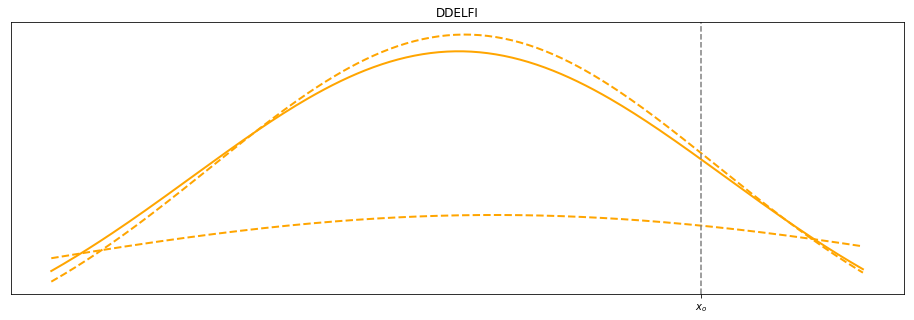

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.408252]: : 14it [00:00, 106.06it/s]  

loss=[ 2.39064717]: : 1627it [00:14, 110.02it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41314173]: : 2it [00:00, 17.51it/s]

loss=[ 2.41199231]: : 1063it [00:18, 58.06it/s]


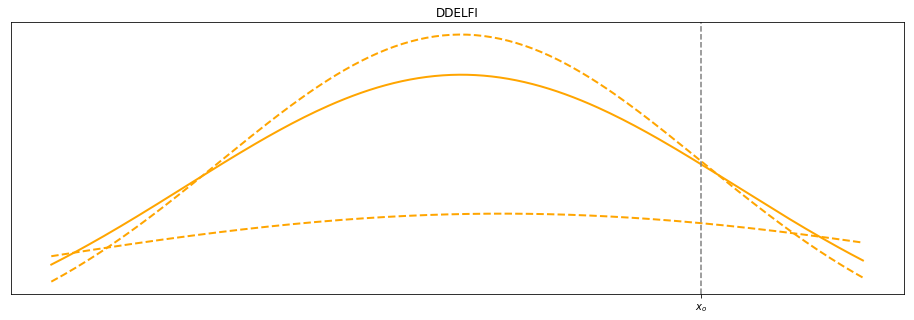

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44438076]: : 3it [00:00, 23.90it/s]

loss=[ 2.40733099]: : 3551it [01:06, 53.01it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39669943]: : 0it [00:00, ?it/s]

loss=[ 2.39669132]: : 1017it [00:08, 121.67it/s]


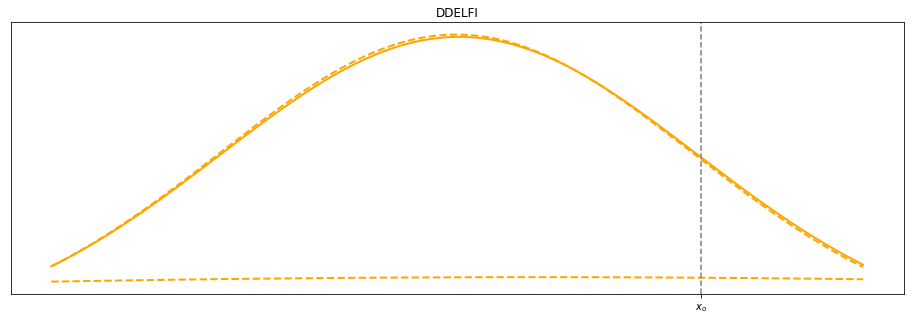

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42991281]: : 3it [00:00, 27.29it/s]

loss=[ 2.39893866]: : 1728it [00:20, 84.73it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40429568]: : 3it [00:00, 27.00it/s]

loss=[ 2.40377927]: : 1037it [00:22, 46.10it/s]


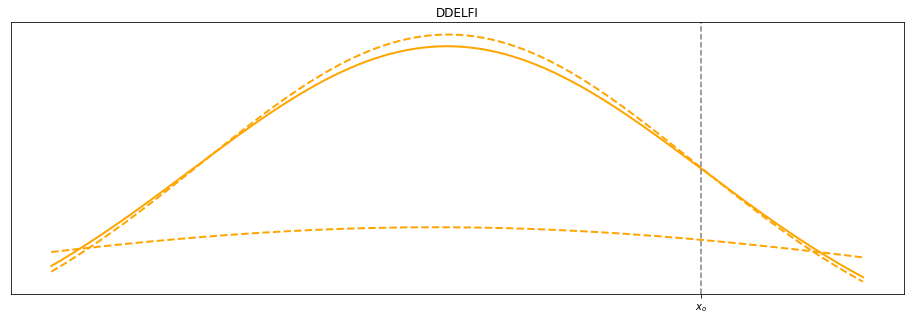

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42314339]: : 13it [00:00, 86.70it/s] 

loss=[ 2.40922713]: : 1609it [00:25, 62.91it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41638184]: : 0it [00:00, ?it/s]

loss=[ 2.41564655]: : 1043it [00:15, 65.79it/s]


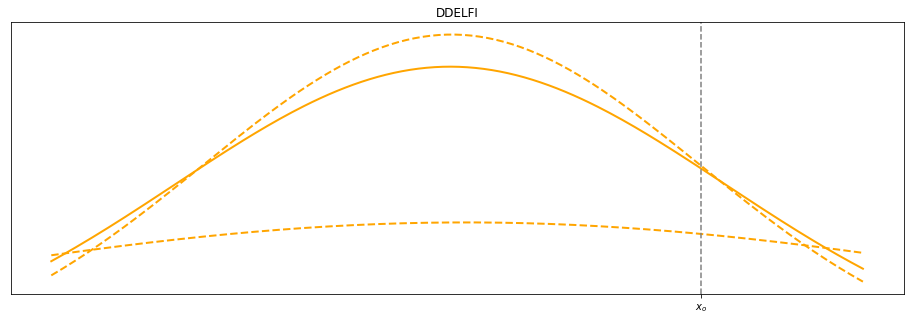

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.46555066]: : 4it [00:00, 36.70it/s]

loss=[ 2.42687201]: : 12163it [03:13, 62.83it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39165449]: : 1001it [00:10, 99.17it/s] 


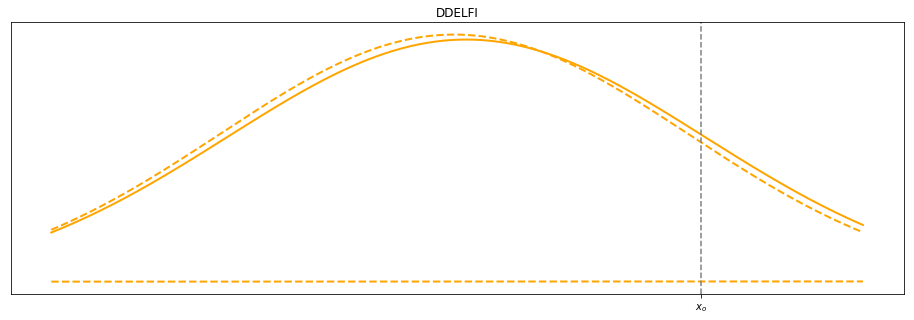

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44767046]: : 4it [00:00, 25.42it/s]

loss=[ 2.41935205]: : 2294it [00:45, 50.90it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41127181]: : 8it [00:00, 64.01it/s]

loss=[ 2.41124892]: : 1034it [00:16, 62.23it/s]


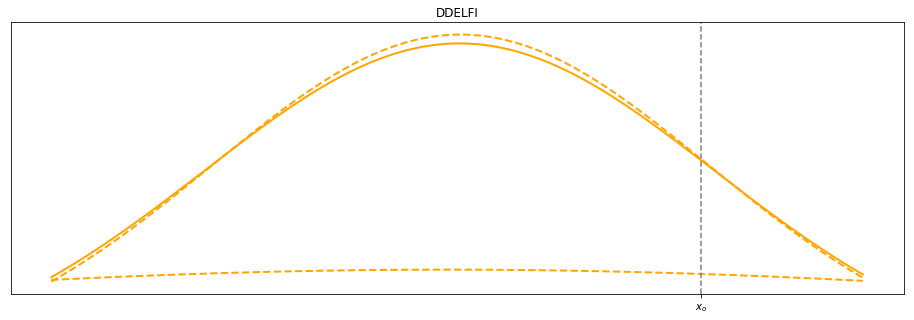

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41731095]: : 0it [00:00, ?it/s]

loss=[ 2.39266634]: : 1295it [00:24, 52.32it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40544033]: : 4it [00:00, 29.33it/s]

loss=[ 2.40369987]: : 1092it [00:21, 51.71it/s]


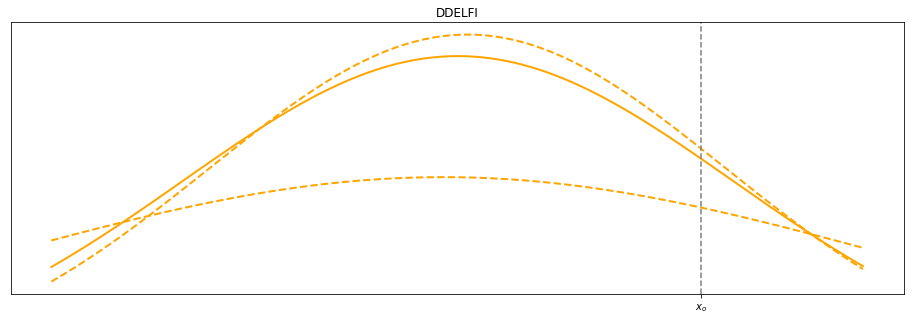

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43493581]: : 4it [00:00, 35.31it/s]

loss=[ 2.40374207]: : 1909it [00:36, 52.22it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40417027]: : 2it [00:00, 19.13it/s]

loss=[ 2.4037323]: : 1032it [00:20, 50.02it/s]


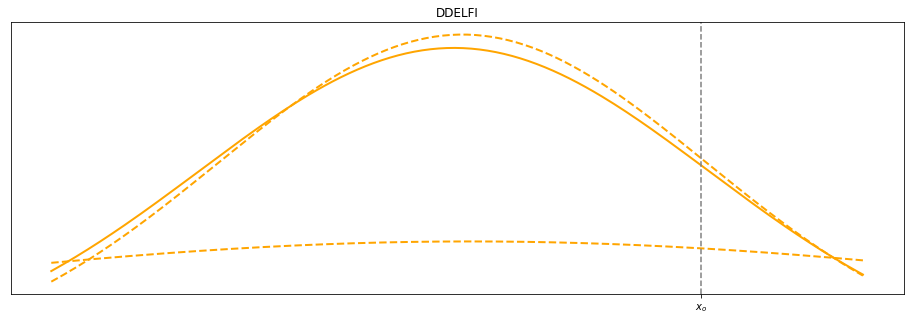

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43658257]: : 5it [00:00, 41.26it/s]

loss=[ 2.40746284]: : 1842it [00:36, 50.65it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39590287]: : 5it [00:00, 46.50it/s]

loss=[ 2.39583707]: : 1020it [00:14, 71.65it/s]


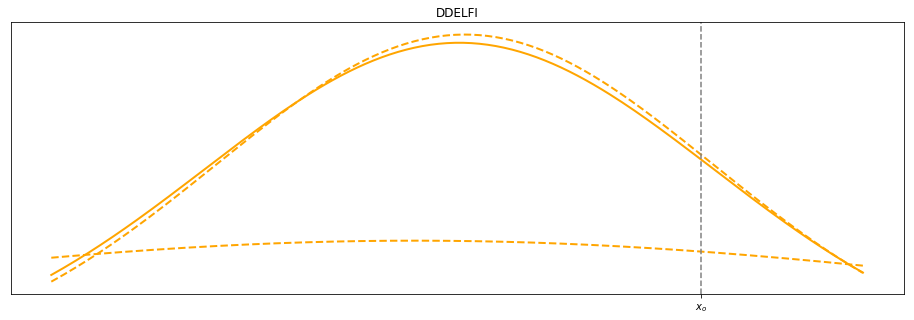

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41429257]: : 18it [00:00, 127.34it/s]

loss=[ 2.39724541]: : 1894it [00:14, 126.34it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4127965]: : 0it [00:00, ?it/s] 

loss=[ 2.41247344]: : 1042it [00:19, 53.72it/s]


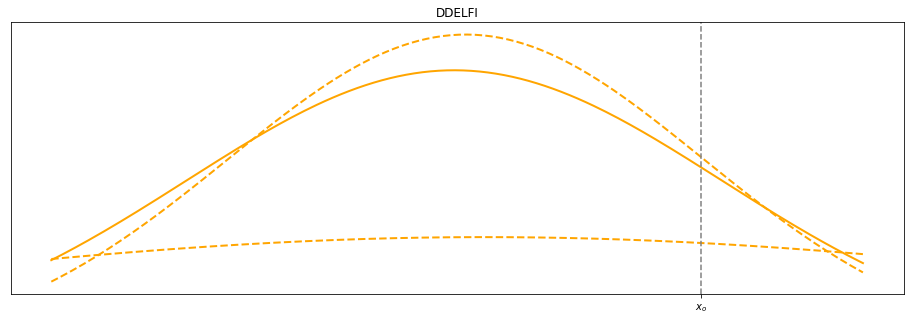

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41050053]: : 10it [00:00, 60.31it/s]

loss=[ 2.391752]: : 1871it [00:34, 54.91it/s]  


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39994812]: : 0it [00:00, ?it/s]

loss=[ 2.39979529]: : 1035it [00:19, 52.55it/s]


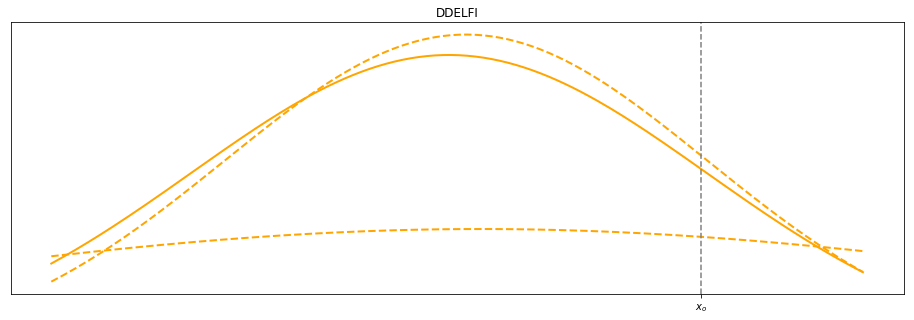

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41761851]: : 4it [00:00, 26.93it/s]

loss=[ 2.39140892]: : 1595it [00:30, 52.17it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39806676]: : 4it [00:00, 29.66it/s]

loss=[ 2.39783025]: : 1048it [00:17, 59.44it/s]


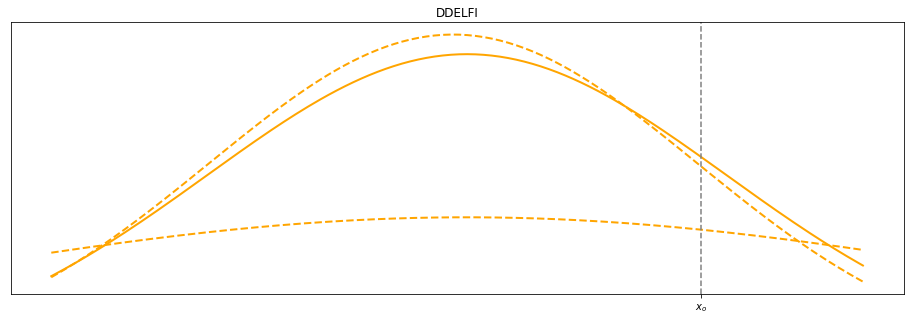

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41830611]: : 18it [00:00, 152.27it/s]

loss=[ 2.4015584]: : 1819it [00:33, 54.86it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39336228]: : 5it [00:00, 40.59it/s]

loss=[ 2.3933382]: : 1056it [00:22, 46.29it/s]


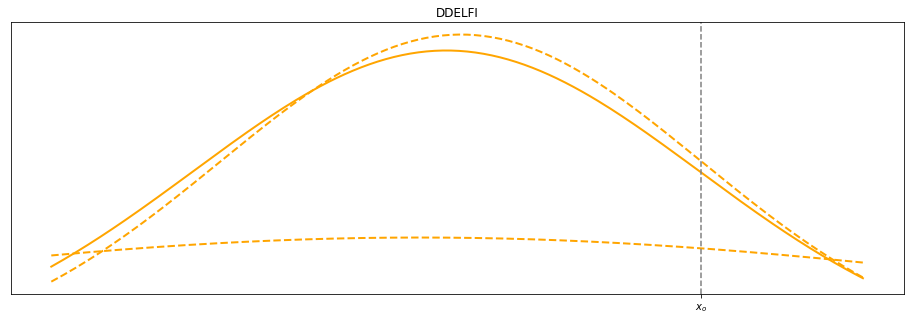

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44348145]: : 3it [00:00, 21.34it/s]

loss=[ 2.41369414]: : 2315it [00:27, 84.42it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40284014]: : 0it [00:00, ?it/s]

loss=[ 2.40277076]: : 1036it [00:23, 43.49it/s]


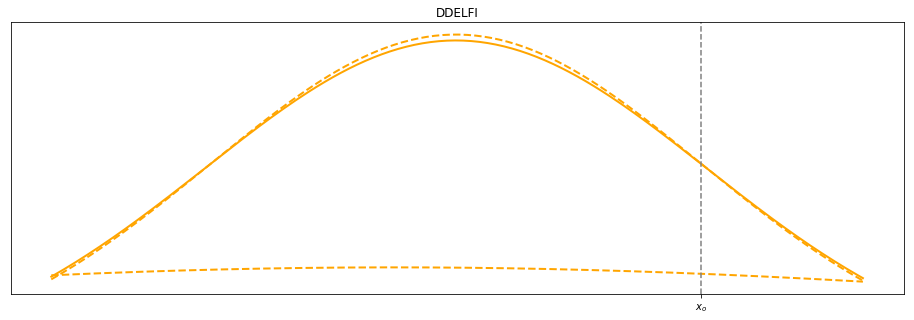

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4406426]: : 5it [00:00, 40.97it/s] 

loss=[ 2.41181731]: : 2053it [00:26, 77.05it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4081521]: : 0it [00:00, ?it/s] 

loss=[ 2.40807414]: : 1057it [00:20, 52.80it/s]


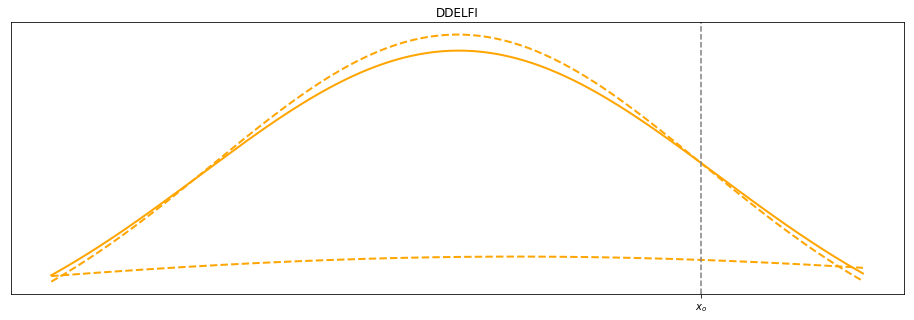

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43599606]: : 0it [00:00, ?it/s]

loss=[ 2.40292549]: : 2098it [00:46, 45.19it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40759659]: : 11it [00:00, 98.70it/s] 

loss=[ 2.40754962]: : 1036it [00:19, 53.45it/s]


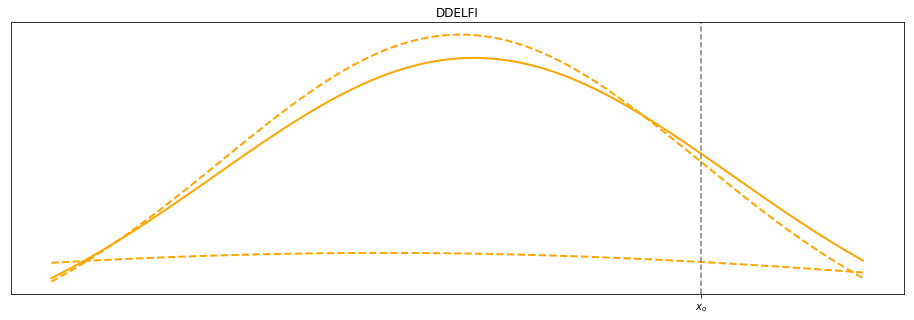

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41767406]: : 4it [00:00, 25.21it/s]

loss=[ 2.39591241]: : 1783it [00:30, 58.51it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40385199]: : 0it [00:00, ?it/s]

loss=[ 2.40367413]: : 1045it [00:17, 60.26it/s]


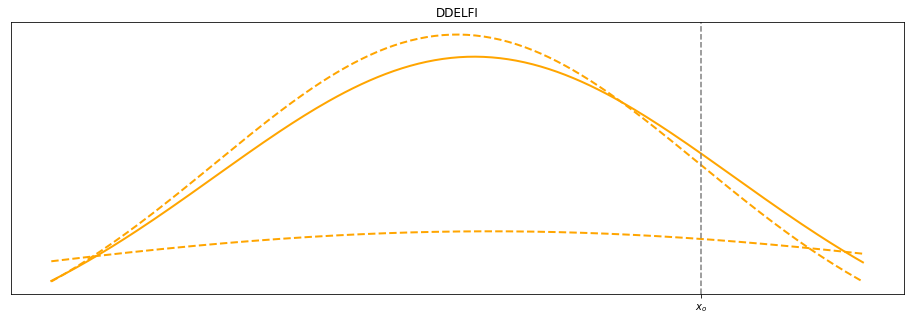

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43033051]: : 14it [00:00, 93.19it/s] 

loss=[ 2.41275954]: : 1938it [00:29, 65.09it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41066861]: : 0it [00:00, ?it/s]

loss=[ 2.41066122]: : 1041it [00:10, 102.74it/s]


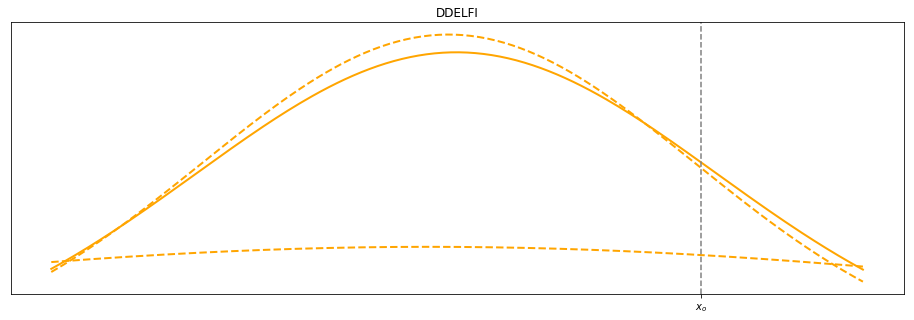

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.46453214]: : 0it [00:00, ?it/s]

loss=[ 2.42797947]: : 16201it [04:43, 57.17it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40002847]: : 0it [00:00, ?it/s]

loss=[ 2.40002561]: : 1018it [00:24, 41.18it/s]


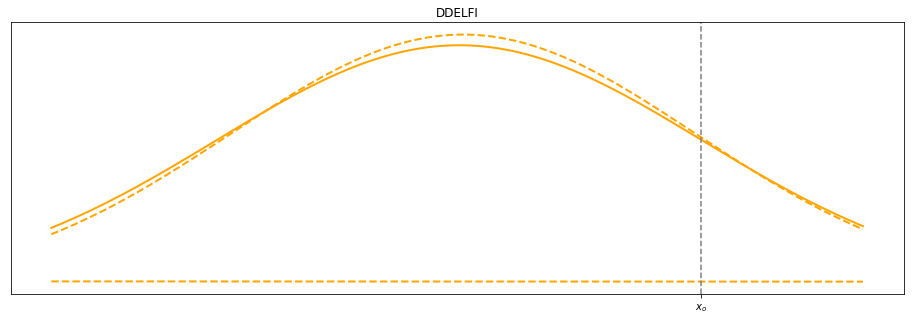

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4511137]: : 3it [00:00, 28.14it/s]

loss=[ 2.41697264]: : 2970it [01:04, 46.16it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4121151]: : 0it [00:00, ?it/s] 

loss=[ 2.4121089]: : 1038it [00:25, 40.73it/s] 


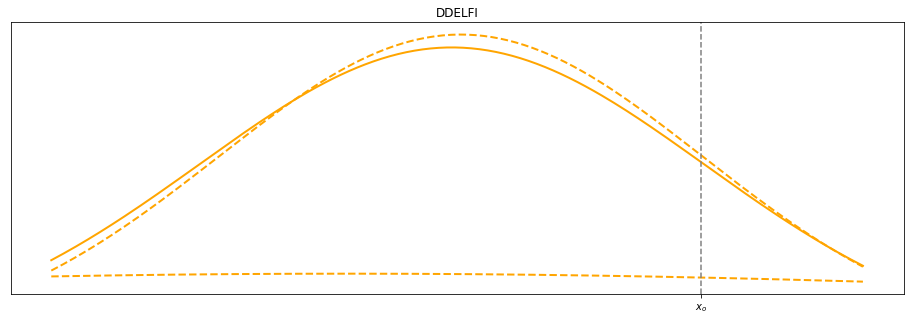

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41826844]: : 13it [00:00, 113.40it/s]

loss=[ 2.3963716]: : 2101it [00:47, 44.47it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40536022]: : 9it [00:00, 75.74it/s]

loss=[ 2.40528917]: : 1019it [00:17, 58.33it/s]


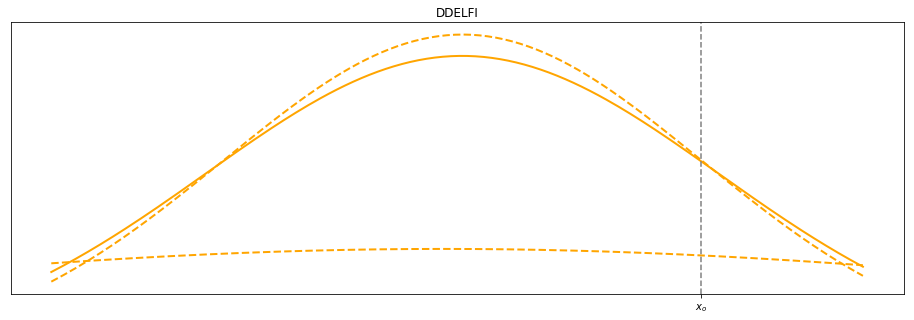

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42695379]: : 6it [00:00, 41.27it/s]

loss=[ 2.40215445]: : 2311it [00:24, 95.91it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40037346]: : 11it [00:00, 99.97it/s]

loss=[ 2.40032029]: : 1057it [00:10, 98.09it/s]


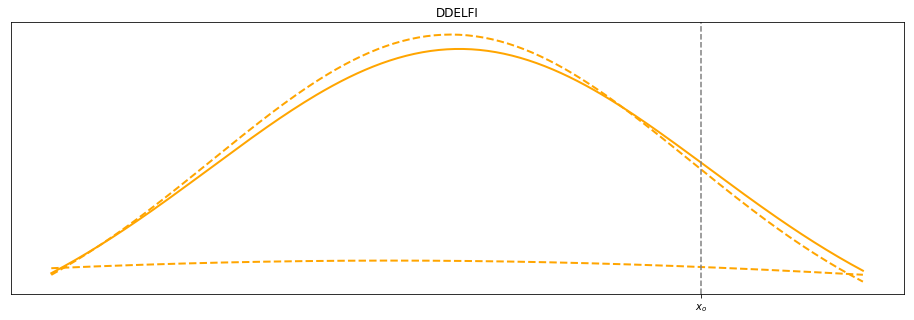

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41529775]: : 9it [00:00, 69.77it/s]

loss=[ 2.39746809]: : 1478it [00:13, 111.26it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40737033]: : 8it [00:00, 59.55it/s]

loss=[ 2.40735364]: : 1050it [00:10, 96.42it/s]


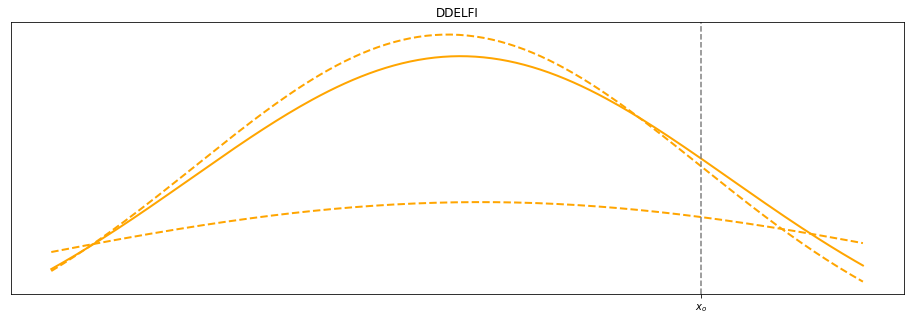

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41519785]: : 18it [00:00, 121.73it/s]

loss=[ 2.40096474]: : 1934it [00:20, 93.30it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41660023]: : 13it [00:00, 101.09it/s]

loss=[ 2.41649842]: : 1066it [00:11, 92.48it/s]


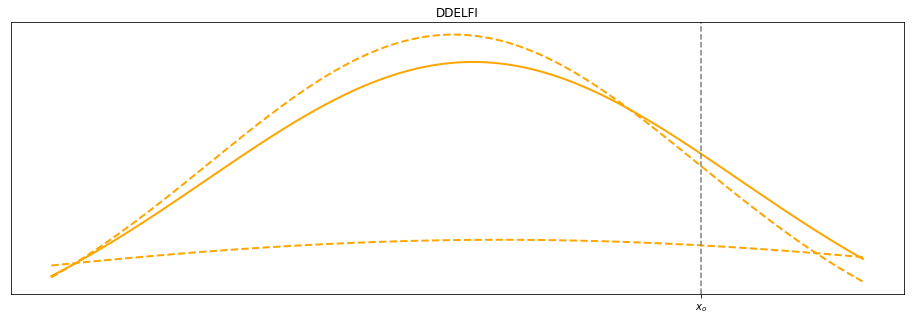

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42008734]: : 9it [00:00, 59.01it/s]

loss=[ 2.39598179]: : 2546it [00:24, 104.23it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39849734]: : 6it [00:00, 42.04it/s]

loss=[ 2.39843965]: : 1031it [00:19, 53.42it/s]


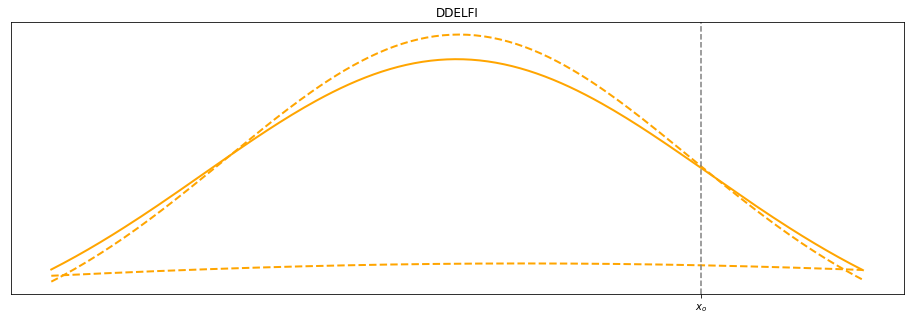

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.3941853]: : 7it [00:00, 43.89it/s] 

loss=[ 2.376544]: : 1302it [00:22, 57.67it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40481925]: : 7it [00:00, 44.74it/s]

loss=[ 2.40394926]: : 1075it [00:19, 56.43it/s]


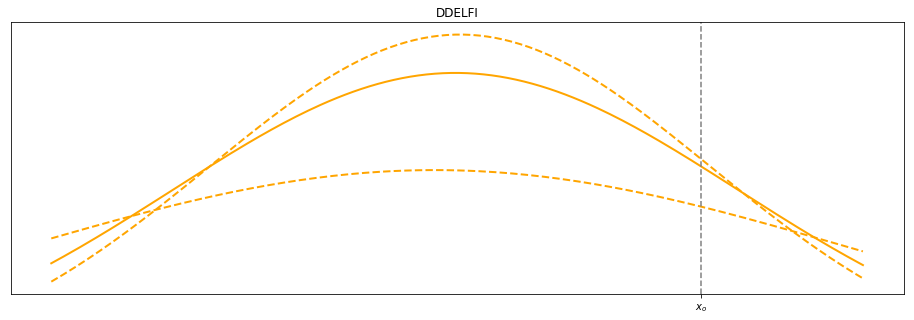

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44305754]: : 8it [00:00, 54.05it/s]

loss=[ 2.4147191]: : 5307it [01:34, 56.44it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40825772]: : 9it [00:00, 71.27it/s]

loss=[ 2.40825462]: : 1022it [00:18, 56.66it/s]


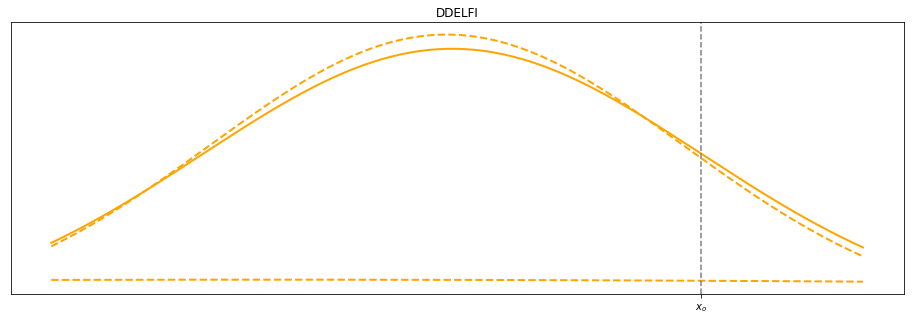

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43281865]: : 6it [00:00, 41.43it/s]

loss=[ 2.4092114]: : 1617it [00:28, 57.70it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39349008]: : 22it [00:00, 128.66it/s]

loss=[ 2.3934772]: : 1071it [00:05, 202.51it/s]


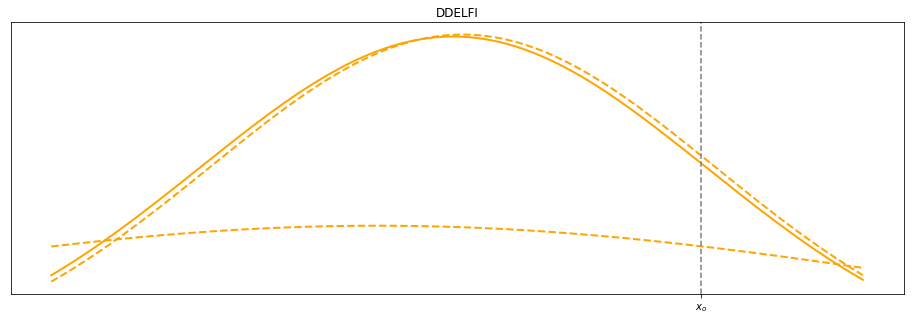

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42529988]: : 6it [00:00, 40.80it/s]

loss=[ 2.39727592]: : 2008it [00:34, 58.06it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41152668]: : 6it [00:00, 41.59it/s]

loss=[ 2.41151309]: : 1058it [00:18, 56.92it/s]


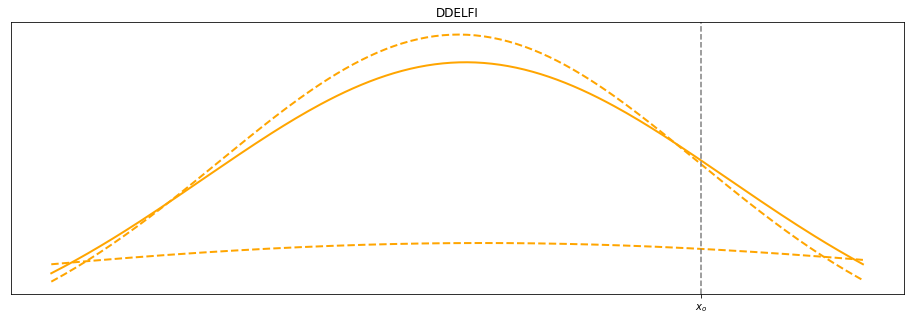

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41570449]: : 7it [00:00, 42.44it/s]

loss=[ 2.39299178]: : 1622it [00:28, 55.97it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41021323]: : 17it [00:00, 107.35it/s]

loss=[ 2.41020131]: : 1075it [00:05, 192.16it/s]


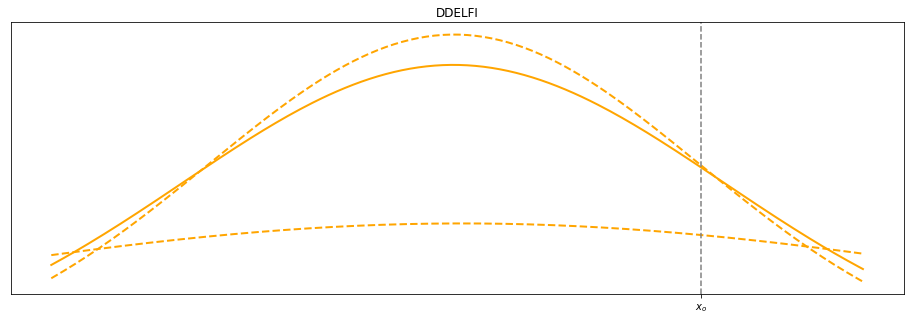

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42776108]: : 7it [00:00, 49.14it/s]

loss=[ 2.40490651]: : 1822it [00:31, 57.35it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40945435]: : 6it [00:00, 39.67it/s]

loss=[ 2.40945005]: : 1020it [00:17, 56.93it/s]


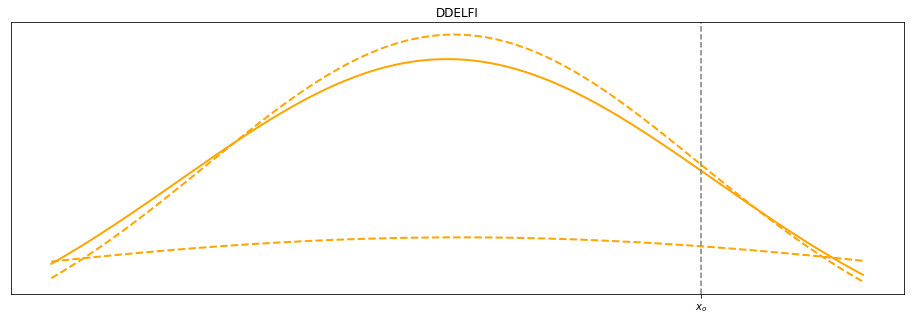

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42044783]: : 6it [00:00, 36.52it/s]

loss=[ 2.39739394]: : 1540it [00:26, 57.36it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.38723469]: : 21it [00:00, 120.36it/s]

loss=[ 2.38721704]: : 1018it [00:05, 199.21it/s]


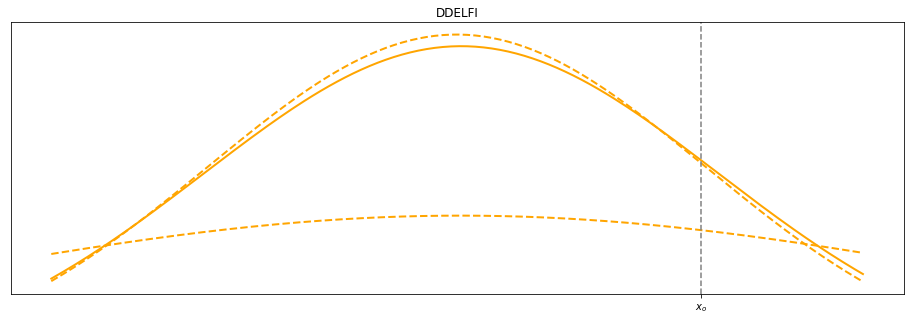

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40632629]: : 22it [00:00, 130.00it/s]

loss=[ 2.39568567]: : 1986it [00:34, 57.64it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41518021]: : 8it [00:00, 56.30it/s]

loss=[ 2.41510034]: : 1031it [00:17, 57.53it/s]


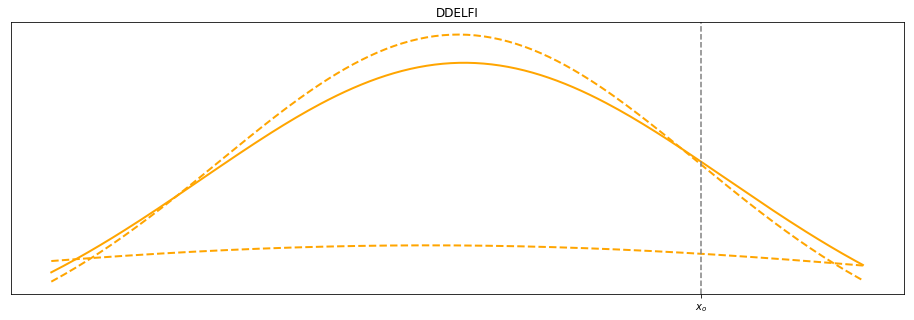

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42412686]: : 6it [00:00, 35.86it/s]

loss=[ 2.39897752]: : 1715it [00:30, 55.56it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40440369]: : 6it [00:00, 40.13it/s]

loss=[ 2.40438008]: : 1054it [00:18, 57.54it/s]


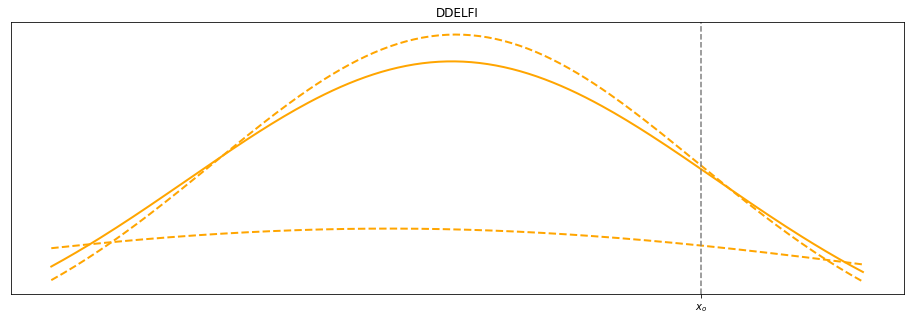

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42926598]: : 5it [00:00, 37.13it/s]

loss=[ 2.40395331]: : 1553it [00:27, 56.53it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.38904953]: : 6it [00:00, 39.42it/s]

loss=[ 2.38904953]: : 1006it [00:18, 55.23it/s]


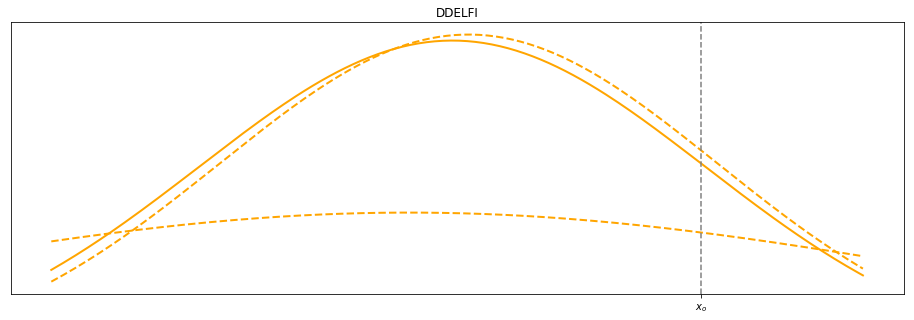

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42272496]: : 7it [00:00, 46.50it/s]

loss=[ 2.40079904]: : 1636it [00:28, 57.03it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39669776]: : 6it [00:00, 35.67it/s]

loss=[ 2.39669657]: : 1042it [00:18, 56.35it/s]


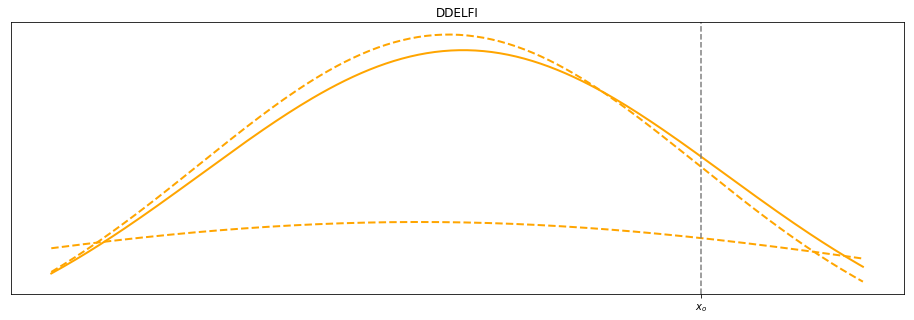

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.3927846]: : 22it [00:00, 120.22it/s] 

loss=[ 2.38714147]: : 1451it [00:07, 193.60it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40284228]: : 7it [00:00, 49.68it/s]

loss=[ 2.4024899]: : 1035it [00:18, 57.32it/s] 


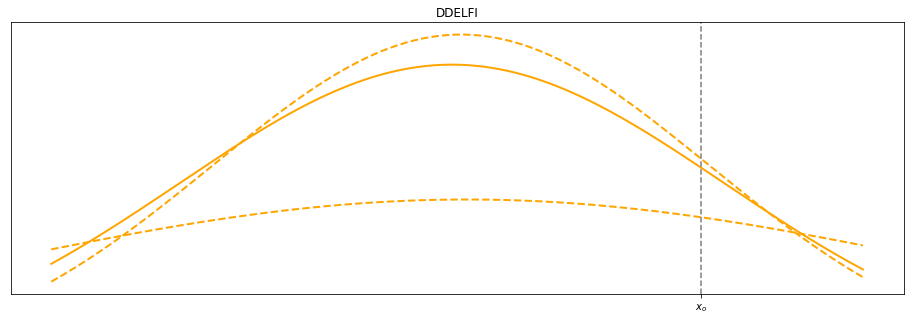

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43472314]: : 6it [00:00, 39.65it/s]

loss=[ 2.40437508]: : 3721it [01:05, 57.09it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40664744]: : 5it [00:00, 37.25it/s]

loss=[ 2.40664601]: : 1012it [00:17, 57.04it/s]


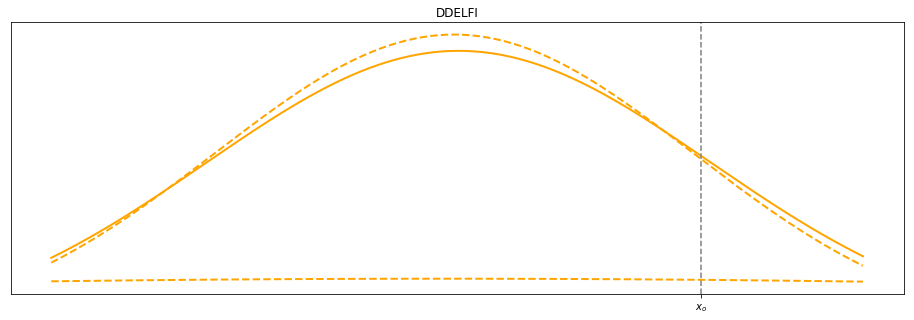

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41953492]: : 5it [00:00, 31.83it/s]

loss=[ 2.39507747]: : 1697it [00:29, 56.80it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.39943314]: : 22it [00:00, 126.21it/s]

loss=[ 2.39942193]: : 1003it [00:05, 197.60it/s]


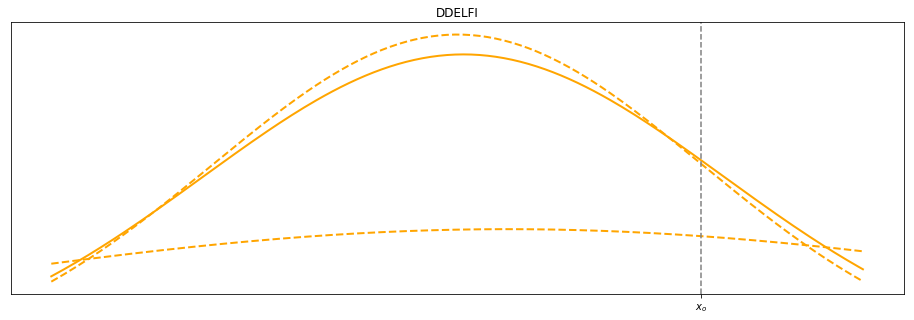

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41948104]: : 21it [00:00, 118.95it/s]

loss=[ 2.4099381]: : 2193it [00:31, 68.84it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41504264]: : 7it [00:00, 51.15it/s]

loss=[ 2.41499615]: : 1051it [00:18, 56.18it/s]


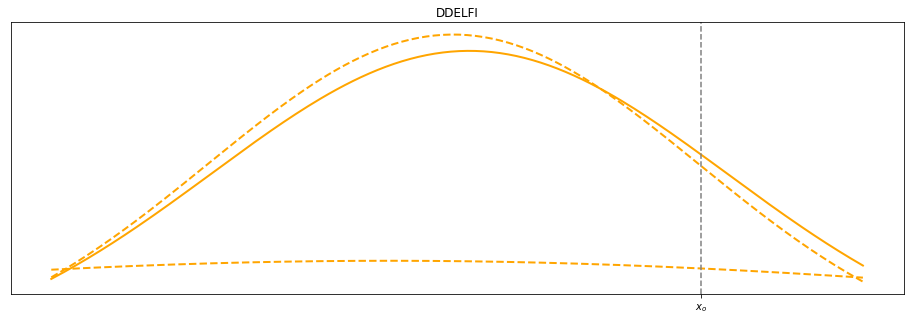

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43082309]: : 7it [00:00, 42.01it/s]

loss=[ 2.40608621]: : 2061it [00:36, 56.64it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.38800097]: : 7it [00:00, 54.28it/s]

loss=[ 2.38791776]: : 1060it [00:18, 57.81it/s]


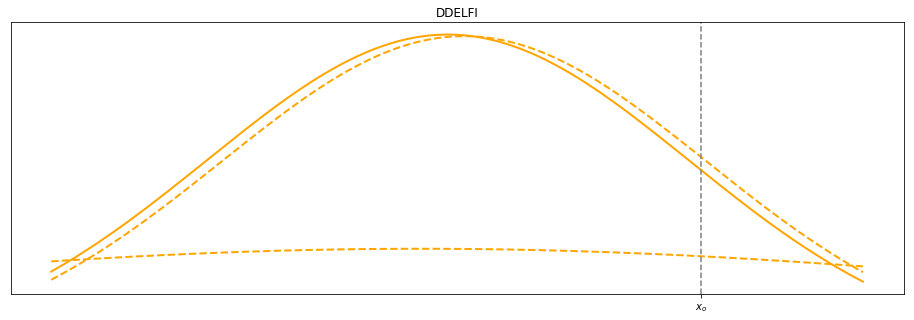

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44351292]: : 8it [00:00, 48.57it/s]

loss=[ 2.41767931]: : 3317it [00:58, 56.73it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.3927803]: : 6it [00:00, 42.91it/s] 

loss=[ 2.39277172]: : 1039it [00:18, 56.67it/s]


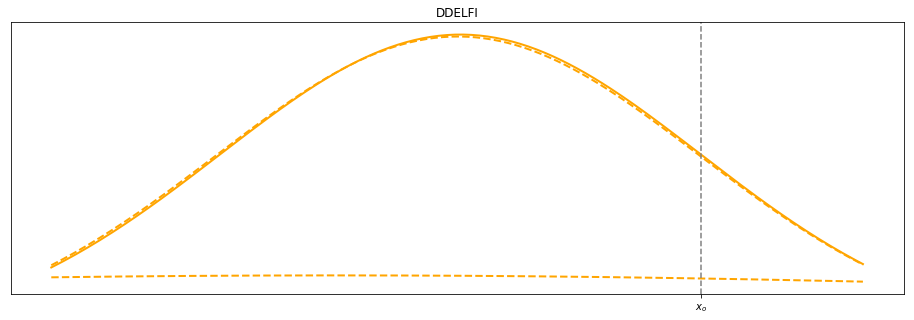

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43711138]: : 6it [00:00, 38.16it/s]

loss=[ 2.41347814]: : 1866it [00:32, 56.79it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40987086]: : 7it [00:00, 47.85it/s]

loss=[ 2.40984869]: : 1060it [00:18, 56.55it/s]


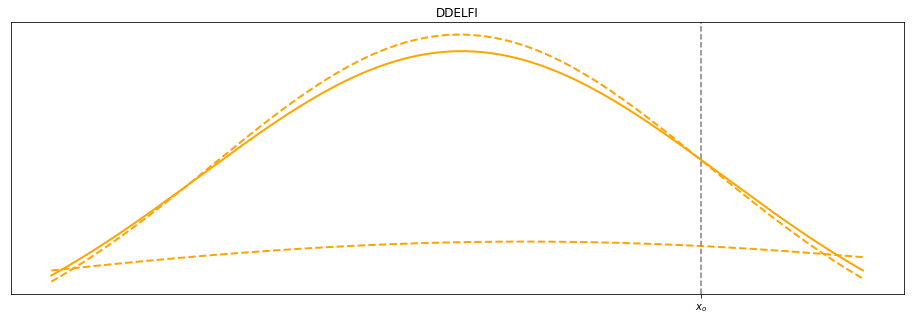

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42986727]: : 7it [00:00, 44.53it/s]

loss=[ 2.40987492]: : 1563it [00:27, 56.83it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40297341]: : 6it [00:00, 38.56it/s]

loss=[ 2.40296125]: : 1044it [00:18, 56.92it/s]


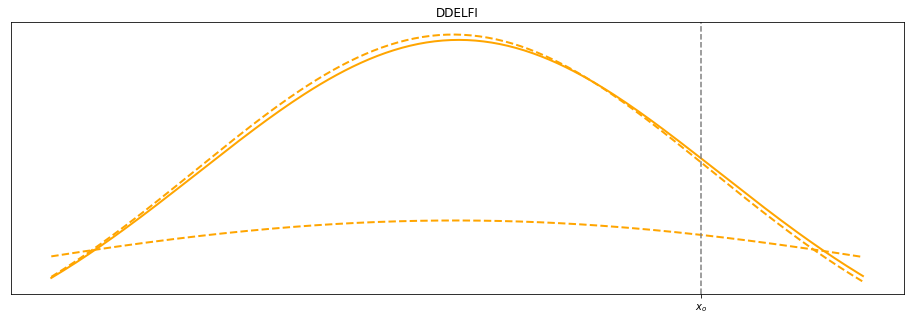

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41188264]: : 8it [00:00, 52.10it/s]

loss=[ 2.39153051]: : 1415it [00:24, 56.71it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40619016]: : 6it [00:00, 41.38it/s]

loss=[ 2.40558243]: : 1058it [00:18, 56.87it/s]


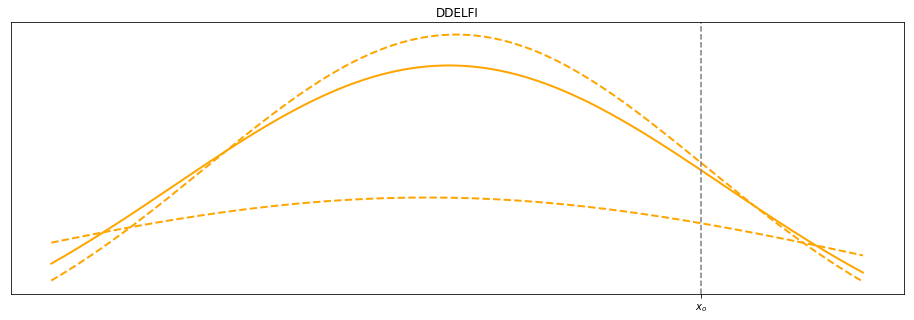

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43316102]: : 6it [00:00, 38.82it/s]

loss=[ 2.40921617]: : 1854it [00:32, 57.33it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40964293]: : 6it [00:00, 40.12it/s]

loss=[ 2.40963626]: : 1037it [00:17, 58.45it/s]


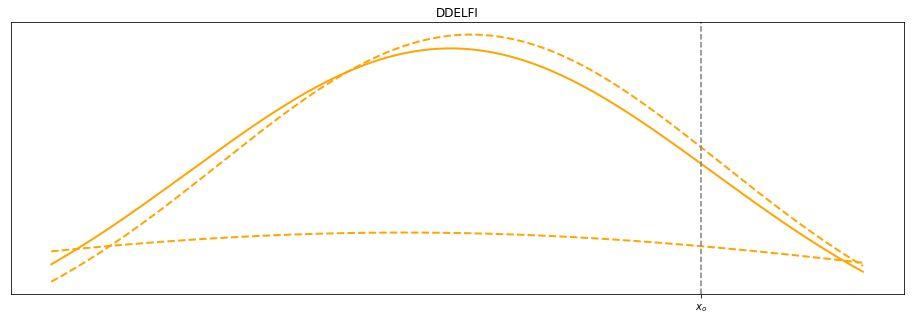

In [15]:
std_params = params

algos = [ 'DDELFI' ] #'CDELFI', 'SNPE', 'kSNPE', 'DDELFI' ]
out = { algo : [] for algo in algos }

for r in range(params.n_runs):
    for algo in algos:
        out[algo].append(run_panel(algo, params, seed=params.seed + r))
        
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r in range(params.n_runs):
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r, posterior in enumerate(posteriors[0:]):
    plot_pdf(posterior, 
             lims=[-params.prior_width,params.prior_width],  
             pdf2=params.gt,
             gt=params.true_params, 
             figsize=(9,9));

In [ ]:
for pred in preds[1:]:
    lhs = multiply_dists(pred['proposal'], pred['posterior'], (-params.prior_width * 5, params.prior_width * 5))
    rhs = multiply_dists(pred['prior'], pred['qphi'], (-params.prior_width * 5, params.prior_width * 5))
    
    plot_pdf(lhs, 
             pdf2 = rhs,
             lims=[-params.prior_width,params.prior_width],  
             figsize=(9,9));

In [ ]:
pred = preds[-1]

trainer = MoGTrainer(prop=pred['proposal'], 
                     prior=pred['prior'], 
                     qphi=pred['qphi'], 
                     n_components=params.n_comps, 
                     nsamples=10000)
            
trainer.train(nsteps=-1)
            
posterior = trainer.get_mog()

In [ ]:
plot_pdf(posterior, 
         pdf2 = params.gt,
         lims=[-params.prior_width,params.prior_width],  
         gt=params.true_params, 
         figsize=(9,9));